In [24]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

## README

The project code contains an LSTM model to classify a given data point i.e. ball_state as alive or not. The idea is to train a model while saving the weights and allowing for a delay of 100 frames which means looking ahead in the future to 100 next data points. I list some points for this exercise as follows:

- Each data point is a 5-dim vector which is by no means exhaustive and needs to involve player data as well. (flatten the frame object). Also, something like PCA could be applied to get an idea regarding the prediction power of the various features.
- The data is sequential which is why I decide to take the difference between consecutive frames so as te capture the change/movement. 
- Thinking about possible solutions, _Hidden Markov Models_ using _smoothing_ seems to be another option to smooth (impute) the the data-point (with missing label) using past and future (100 frame delay) data. Additionally, anomaly detection methods (non neural approach) like ARMA or ngrams with sliding windows could also be considered for sequential prediction. Additionally, we could also look at clustering appoaches which doesn't concern any sequential nature.
- A major concern however seems to be the large class imbalance with a minimum representation for the minority class which is ball_state = 0. Using SMOTE to synthesize minority class samples could help in training a balanced model.

### I felt the need to look at oversampling the negative class as it was highly under-represented (as follows)

In [4]:
df = pd.read_csv('match_data.csv')
df

height   speed  pos_x  pos_z  possession  ball_state
0         0.11  276.80  18.96 -36.90         0.0         1.0
1         0.11  276.80  18.85 -36.92         0.0         1.0
2         0.11  275.83  18.74 -36.95         0.0         1.0
3         0.11  275.61  18.64 -36.98         0.0         1.0
4         0.11  274.64  18.53 -37.00         0.0         1.0
...        ...     ...    ...    ...         ...         ...
188324    0.11  376.13  35.48  13.84         0.0         1.0
188325    0.11  374.81  35.48  13.90         0.0         1.0
188326    0.11  373.90  35.48  13.97         0.0         1.0
188327    0.11  372.58  35.49  14.03         0.0         1.0
188328    0.11  371.67  35.49  14.09         0.0         1.0

[188329 rows x 6 columns]

In [5]:
df.columns

Index(['height', 'speed', 'pos_x', 'pos_z', 'possession', 'ball_state'], dtype='object')

### SMOTE
Following code is the implementation of Synthetic Minority Over-sampling Technique with optional Tomek link removal.

In [16]:
import random
import math

# for tomek links implementation
from sklearn.neighbors import NearestNeighbors

'''
Function to find the k nearest neighbours
'''
def k_neighbors(curr_row, data, k):
    dist_list = list()
    for idx in range(len(data)):
        dist = euclidean_distance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
    for i in range(k):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours
    
'''
Calculate the Euclidean distance between two vectors
'''
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)

'''
SMOTE function:
    T => Number of minority Samples available
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    returns a list of synthetic samples
'''
def smote(T,N,k,minority_samples):
    
# if N < 100, sample from random percent of minority instances
    if N < 100:
        T = (N/100) * T
        N = 100 # since we changed T now, make N = 100
        
# N controls the number of synthetic samples generated per data point
    N = (int)(N/100)
    synthetic_samples = list()
    
    for i in range(T):
        counter = N
# If k = 0, the nearest neighbour is the point itself.
        if(k):
            nn_list = k_neighbors(minority_samples[i], minority_samples, k)
        else:
            rand_knbr = i
        while counter:
            rand_nn = random.randint(1, len(nn_list) - 1)
            rand_knbr = nn_list[rand_nn]
            sample_row = []
            for attr in range(len(minority_samples[i])):
                diff = minority_samples[rand_knbr][attr] - minority_samples[i][attr]
                rand_gap = random.uniform(0, 1)
                sample_row.append(int(minority_samples[i][attr] + rand_gap*diff))
            synthetic_samples.append    
            synthetic_samples.append(sample_row)
            counter = counter - 1
    
    return synthetic_samples

'''
Wrapper for the SMOTE function:
default tomek_link = False (links are not removed)
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    tomek_links => True: remove tomek_links, False: do not remove
'''
def smote_wrapper(df1, N, k, tomek_links = False):
# Drop these columns from the parent df
    prep_df = df1.copy()
    
# Separate out the fraud and non-fraud instances
    not_fraud_df = prep_df.loc[prep_df['ball_state'] == 1]
    fraud_df = prep_df.loc[prep_df['ball_state'] == 0]
    minority_samples = np.array(fraud_df)
    cols = prep_df.columns
# Generate 'N%' new synthetic samples condsidering 'k' nearest neighbours
    synthetic_fraud_df = pd.DataFrame(smote(len(minority_samples), N, k, minority_samples),
                                      columns=cols)  
    
# intermediate_df -> synthetic + non-fraud samples
    intermediate_df = pd.concat([synthetic_fraud_df, not_fraud_df])

# fraud_df with synthetic samples
    fraud_syn_df = pd.concat([fraud_df, synthetic_fraud_df], sort=False)
    
# Tomek Links
    len_fraud = len(synthetic_fraud_df.values)
    if(tomek_links):
        remove_idx=[]
        intermediate_df_mat = intermediate_df.values
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(intermediate_df)
        distances, indices = nbrs.kneighbors(intermediate_df_mat[:len_fraud])
        for i in indices:
            if i[1] > len_fraud:
                remove_idx.append(i[0])
        needed = list(set(np.arange(len_fraud)) - set(remove_idx))
        needed_df = pd.DataFrame([synthetic_fraud_df.iloc[i] for i in needed])
        
        augmented_fraud_df = pd.concat([fraud_df, needed_df], sort=False)
        
        
        return pd.concat([augmented_fraud_df, not_fraud_df], sort=False)
        

    return pd.concat([fraud_syn_df, not_fraud_df], sort = False)

In [17]:
from sklearn.utils import resample

def downsample_majority_class(df1, percent):
    df = df1.copy()
    
    not_fraud_df = df.loc[df["ball_state"] == 1]
    fraud_df = df.loc[df['ball_state'] == 0]
    if(percent):
        num_samples = int(len(fraud_df) * (100/percent))
    else:
        num_samples = len(fraud_df)
    not_fraud_downsampled = resample(not_fraud_df,
                                    replace = False, # sample without replacement
                                    n_samples = num_samples, # match minority n
                                    random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([not_fraud_downsampled, fraud_df])
    
    return downsampled

In [19]:
# from sklearn.preprocessing import StandardScaler

y = df.drop(['height', 'speed', 'pos_x', 'pos_z', 'possession'], axis=1)
X = df.copy()

# Train-Test Split (if required)
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=3)

# We will Smote the X_train data
# 500% or 5 times the minority samples with 2 nearest neighbours
# Tomek Links not removed if tomek_links is set to false
smoted_df = smote_wrapper(x_train, N = 500, k = 2, tomek_links = True)

# undersampling will have 'percent' amount of samples of the majority class.
# 50% implies -> count(minority samples) = 0.5 * count(majority samples)
smoted_df = downsample_majority_class(smoted_df, percent=20)
print(smoted_df['ball_state'].value_counts())

1.0    1615
0.0     323
Name: ball_state, dtype: int64


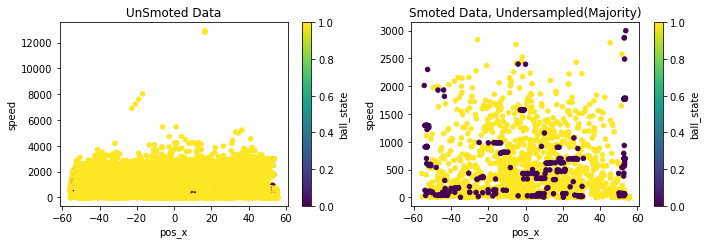

In [28]:
# Scatter Plots to visualize the SMOTE results
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
df.reset_index().plot.scatter(x='pos_x', y='speed', c='ball_state', colormap='viridis',
                               ax=ax, title='UnSmoted Data')
smoted_df.reset_index().plot.scatter(x='pos_x', y='speed', c='ball_state', colormap='viridis', 
                                     ax=ax2, title='Smoted Data, Undersampled(Majority)')
fig.tight_layout()

We now have some negative samples (albeit, synthetic ones) to train our model. This data should now be fed into our model to train a classifier.